# Datawhale 零基础入门数据挖掘-Task4 建模调参 

## 1.内容介绍

1. 线性回归模型：
    - 线性回归对于特征的要求；
    - 处理长尾分布；
    - 理解线性回归模型；
2. 模型性能验证：
    - 评价函数与目标函数；
    - 交叉验证方法；
    - 留一验证方法；
    - 针对时间序列问题的验证；
    - 绘制学习率曲线；
    - 绘制验证曲线；
3. 嵌入式特征选择：
    - Lasso回归；
    - Ridge回归；
    - 决策树；
4. 模型对比：
    - 常用线性模型；
    - 常用非线性模型；
5. 模型调参：
    - 贪心调参方法；
    - 网格调参方法；
    - 贝叶斯调参方法；

## 2.相关原理简要梳理

### 2.1 线性回归模型
线性回归模型的计算方法可以表示为：
$$
label=\sum_{i=1}^{n}w \cdot x
$$
其中，w是现有的特征权重矩阵，x是输入的特征数据矩阵，label是由现有特征权重与输入特征计算出来的标签估计值。

由于线性回归模型假设标签与完美模型预测值误差服从零均值正态分布，所以对于一次性输入所有数据的模型参数优化方法是最大似然估计（由于一般训练数据量较大，该方法计算速度较慢，因此较少使用），对于分批次输入的模型考虑设置学习率，使用梯度下降法、拟牛顿法等方法进行学习。

最基础的算法中，w元素数量在训练最初给定，选取较大或较小的数量分别会导致过拟合与欠拟合，一般会选取较大的模型并加上一个正则化项，防止模型过拟合。

由于其本身假设原因，最适宜于线性回归模型的损失函数是平方损失函数（可由概率学知识推导得出，这里不做展开）。

### 2.2 决策树模型
决策树整个模型可以表示为一个完整的树（分叉数量由具体算法决定），模型的构建过程是一个递归的算法，具体可大致描述为：

* 0.将所有数据初始化为根节点。
* 1.当模型精度达到结束训练要求时，结束训练。
* 2.遍历目前所有节点，选取分类带来分类精度最高的节点，增加一个子节点，若该节点为叶节点，增加两个子节点分别代表两个分类

在模型训练完成之后，考虑可能出现过拟合现象，故可能会加入剪枝过程，简化模型。

### 2.3 GBDT模型
GBDT是一个集成模型，可以看做是很多个基模型的线性相加，其中的基模型就是CART回归树。

CART回归树中，每个非叶节点有且仅有两个子节点，也就是说CART回归树的模型是一个标准的二叉树。

CART回归树是将特征空间按照一定规则划分为一定数量的小块，每个小块有不同的输出。

GBDT是利用梯度下降的方法，将多个CART回归树的输出进行线性组合，最终得到对应的输出

### 2.4 XGBoost模型
Xgboost是GBDT算法的一种很好的工程实现，并且在算法上做了一些优化，主要的优化在一下几点。
首先Xgboost加了一个衰减因子，相当于一个学习率，可以减少加进来的树对于原模型的影响，让树的数量变得更多；其次是在原GBDT模型上加了个正则项，对于树的叶子节点的权重做了一个约束；
还有增加了在随机森林上常用的col subsample的策略；然后使用二阶泰勒展开去拟合损失函数，加快优化的效率；然后最大的地方在于不需要遍历所有可能的分裂点了，它提出了一种估计分裂点的算法。

来源：https://zhuanlan.zhihu.com/p/86816771

### 2.5 LightGBM模型
XGB虽然每次只需要遍历几个可能的分裂节点，然后比较每个分裂节点的信息增益，选择最大的那个进行分割，但比较时需要考虑所有样本带来的信息增益。而LGB只需采用少量的样本计算信息增益，所以速度会快很多。
LGB的优化方法是，在保留大梯度样本的同时，随机地保留一些小梯度样本，同时放大了小梯度样本带来的信息增益。

来源：https://zhuanlan.zhihu.com/p/89360721

## 3. 代码示例

### 3.0 读取数据

In [8]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from operator import itemgetter
warnings.filterwarnings('ignore')

%matplotlib inline
#加上header与index_col使数据读取过程直接使用已有数据作为index，不再自动生成新的index
pd.set_option('display.max_columns', None)#显示所有列

In [9]:
#减少数据使用内存量
#通过调整数据类型，将数值较小的数据改为使用内存使用较小的格式存储
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [17]:
train = reduce_mem_usage(pd.read_csv('myfeature_train.csv',header=0, index_col=0))

Memory usage of dataframe is 469200000.00 MB
Memory usage after optimization is: 66450000.00 MB
Decreased by 85.8%


In [21]:
train.head()

,name,kilometer,price,v_0,v_1,v_2,v_3,v_4,v_11,v_13,v_14,temp,creatDate_201604,creatDate_201603,creatDate_201602,creatDate_201601,creatDate_201511,creatDate_201508,creatDate_201509,creatDate_201506,creatDate_201512,used_time,city,brand_amount,brand_price_average,brand_price_max,brand_price_median,brand_price_min,brand_price_std,brand_price_sum,power_bin,kilometer_max,kilometer_min,brand_amount_max,brand_amount_min,brand_price_average_max,brand_price_average_min,brand_price_max_max,brand_price_max_min,brand_price_median_max,brand_price_median_min,brand_price_min_max,brand_price_min_min,brand_price_std_max,brand_price_std_min,brand_price_sum_max,brand_price_sum_min,model_30.0,model_40.0,model_115.0,model_109.0,model_110.0,model_24.0,model_13.0,model_26.0,model_19.0,model_7.0,model_1.0,model_48.0,model_65.0,model_138.0,model_105.0,model_114.0,model_-0.0,model_8.0,model_78.0,model_21.0,model_3.0,model_4.0,model_31.0,model_121.0,model_75.0,model_17.0,model_107.0,model_16.0,model_111.0,model_47.0,model_5.0,model_44.0,model_200.0,model_155.0,model_87.0,model_20.0,model_22.0,model_63.0,model_49.0,model_29.0,model_88.0,model_60.0,model_73.0,model_39.0,model_23.0,model_11.0,model_69.0,model_167.0,model_199.0,model_178.0,model_101.0,model_6.0,model_10.0,model_57.0,model_33.0,model_32.0,model_52.0,model_46.0,model_74.0,model_93.0,model_125.0,model_41.0,model_127.0,model_104.0,model_98.0,model_68.0,model_156.0,model_116.0,model_170.0,model_160.0,model_85.0,model_80.0,model_143.0,model_77.0,model_166.0,model_53.0,model_66.0,model_203.0,model_14.0,model_42.0,model_119.0,model_174.0,model_177.0,model_210.0,model_36.0,model_238.0,model_70.0,model_58.0,model_126.0,model_84.0,model_97.0,model_108.0,model_192.0,model_64.0,model_15.0,model_95.0,model_54.0,model_142.0,model_55.0,model_218.0,model_222.0,model_163.0,model_76.0,model_83.0,model_122.0,model_18.0,model_124.0,model_106.0,model_59.0,model_228.0,model_164.0,model_165.0,model_145.0,model_94.0,model_186.0,model_220.0,model_179.0,model_67.0,model_71.0,model_25.0,model_144.0,model_212.0,model_172.0,model_168.0,model_206.0,model_152.0,model_123.0,model_182.0,model_38.0,model_117.0,model_132.0,model_99.0,model_183.0,model_219.0,model_62.0,model_173.0,model_82.0,model_34.0,model_102.0,model_213.0,model_92.0,model_162.0,model_43.0,model_175.0,model_35.0,model_61.0,model_113.0,model_137.0,model_226.0,model_161.0,model_134.0,model_202.0,model_130.0,model_146.0,model_139.0,model_45.0,model_112.0,model_227.0,model_195.0,model_2.0,model_51.0,model_232.0,model_129.0,model_135.0,model_169.0,model_191.0,model_148.0,model_140.0,model_9.0,model_201.0,model_237.0,model_221.0,model_171.0,model_196.0,model_204.0,model_185.0,model_147.0,model_189.0,model_193.0,model_214.0,model_56.0,model_180.0,model_100.0,model_187.0,model_91.0,model_208.0,model_150.0,model_131.0,model_28.0,model_188.0,model_149.0,model_12.0,model_118.0,model_184.0,model_120.0,model_50.0,model_136.0,model_176.0,model_223.0,model_79.0,model_37.0,model_133.0,model_27.0,model_246.0,model_96.0,model_153.0,model_103.0,model_194.0,model_154.0,model_240.0,model_225.0,model_90.0,model_86.0,model_207.0,model_234.0,model_141.0,model_181.0,model_211.0,model_197.0,model_81.0,model_217.0,model_216.0,model_157.0,model_243.0,model_239.0,model_159.0,model_244.0,model_128.0,model_72.0,model_158.0,model_190.0,model_215.0,model_205.0,model_151.0,model_224.0,model_236.0,model_231.0,model_230.0,model_89.0,model_198.0,model_209.0,model_233.0,model_241.0,model_229.0,model_nan,model_235.0,model_245.0,model_242.0,model_247.0,brand_6,brand_1,brand_15,brand_10,brand_5,brand_4,brand_14,brand_7,brand_9,brand_0,brand_27,brand_21,brand_16,brand_3,brand_25,brand_13,brand_37,brand_11,brand_24,brand_19,brand_8,brand_17,brand_18,brand_33,brand_30,brand_29,brand_28,brand_20,brand_22,brand_12,brand_26,brand_38,brand_36,brand_32,brand_34,brand_23,brand_31,brand_35,brand_2,brand_39,bodyType_1.0,bodyType_2.0,bodyType_-0.0,bodyType_5.0,bodyType_3.0,bodyType_nan,bodyType_6.0,bodyType_

In [26]:
continuous_feature_names = ['name','kilometer','price','v_0','v_1','v_2','v_3','v_4','v_11','v_13','v_14','used_time','city','brand_amount','brand_price_average','brand_price_max','brand_price_median',
                            'brand_price_min','brand_price_std','brand_price_sum','power_bin','kilometer_max','kilometer_min','brand_amount_max','brand_amount_min','brand_price_average_max','brand_price_average_min',
                            'brand_price_max_max','brand_price_max_min','brand_price_median_max','brand_price_median_min','brand_price_min_max','brand_price_min_min','brand_price_std_max','brand_price_std_min',
                            'brand_price_std_min','brand_price_sum_max','brand_price_sum_min']

### 3.1 线性回归 & 五折交叉验证

In [27]:
train = train.fillna(0).reset_index(drop=True)

In [36]:
lr_train = train[continuous_feature_names]
train_X = lr_train.drop('price',axis=1)
train_yplt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show() = lr_train['price']
train_X.head()

,name,kilometer,v_0,v_1,v_2,v_3,v_4,v_11,v_13,v_14,used_time,city,brand_amount,brand_price_average,brand_price_max,brand_price_median,brand_price_min,brand_price_std,brand_price_sum,power_bin,kilometer_max,kilometer_min,brand_amount_max,brand_amount_min,brand_price_average_max,brand_price_average_min,brand_price_max_max,brand_price_max_min,brand_price_median_max,brand_price_median_min,brand_price_min_max,brand_price_min_min,brand_price_std_max,brand_price_std_min,brand_price_std_min,brand_price_sum_max,brand_price_sum_min
0,736,0.827637,43.34375,3.966797,0.050262,2.160156,1.143555,2.804688,0.795410,0.914551,4384.0,1.0,0.324463,0.073853,0.586914,0.029266,0.002064,0.186890,0.211548,5.0,15.0,0.5,31488.0,9.0,36160.0,1016.5,99999.0,2900.0,29984.0,950.0,980.0,11.0,22624.0,554.0,554.0,174253296.0,39488.0
1,2262,1.000000,45.31250,5.234375,0.137939,1.380859,-1.421875,2.095703,-1.722656,0.245483,4756.0,4.0,0.437988,0.234985,0.999023,0.191040,0.004128,0.399414,0.733887,0.0,15.0,0.5,31488.0,9.0,36160.0,1016.5,99999.0,2900.0,29984.0,950.0,980.0,11.0,22624.0,554.0,554.0,174253296.0,39488.0
2,14874,0.827637,45.96875,4.824219,1.319336,-0.998535,-0.997070,1.803711,-0.832520,-0.229980,4384.0,2.0,0.046051,0.251465,0.433594,0.260010,0.091858,0.220581,0.082275,16.0,15.0,0.5,31488.0,9.0,36160.0,1016.5,99999.0,2900.0,29984.0,950.0,980.0,11.0,22624.0,554.0,554.0,174253296.0,39488.0
3,71865,1.000000,45.68750,4.492188,-0.050629,0.883789,-2.228516,1.286133,-2.437500,-0.478760,7124.0,0.0,0.452393,0.212158,0.979492,0.153198,0.004128,0.382080,0.692383,19.0,15.0,0.5,31488.0,9.0,36160.0,1016.5,99999.0,2900.0,29984.0,950.0,980.0,11.0,22624.0,554.0,554.0,174253296.0,39488.0
4,111080,0.310303,44.37500,2.031250,0.572266,-1.571289,2.246094,0.910645,2.833984,1.923828,1531.0,6.0,0.147949,0.065125,0.294434,0.046478,0.009285,0.126343,0.088318,6.0,15.0,0.5,31488.0,9.0,36160.0,1016.5,99999.0,2900.0,29984.0,950.0,980.0,11.0,22624.0,554.0,554.0,174253296.0,39488.0


In [37]:
from sklearn.linear_model import LinearRegression

In [38]:
model = LinearRegression(normalize=True)

In [39]:
model = model.fit(train_X, train_y)

In [40]:
'intercept:'+ str(model.intercept_)

sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('brand_amount', 26146.18432292137),
 ('city', 7802.841710426652),
 ('v_1', 5266.416094464258),
 ('v_0', 2707.1239090985005),
 ('brand_price_average', 2636.3570533430093),
 ('v_3', 634.2205305446286),
 ('v_2', 446.0385241320247),
 ('v_13', 355.02662097260645),
 ('used_time', 41.74984384271103),
 ('brand_price_sum', 3.99956926097036),
 ('name', 0.0017243070099197237),
 ('power_bin', 0.0),
 ('kilometer_max', 0.0),
 ('kilometer_min', 0.0),
 ('brand_amount_max', 0.0),
 ('brand_amount_min', 0.0),
 ('brand_price_average_max', 0.0),
 ('brand_price_average_min', 0.0),
 ('brand_price_max_max', 0.0),
 ('brand_price_max_min', 0.0),
 ('brand_price_median_max', 0.0),
 ('brand_price_median_min', 0.0),
 ('brand_price_min_max', 0.0),
 ('brand_price_min_min', 0.0),
 ('brand_price_std_max', 0.0),
 ('brand_price_std_min', 0.0),
 ('brand_price_sum_max', 0.0),
 ('v_14', -0.10866842407812097),
 ('v_11', -444.8130994270978),
 ('brand_price_min', -1765.0860486279444),
 ('price', -2134.591077503123),
 ('brand

In [41]:
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

The predicted price is obvious different from true price


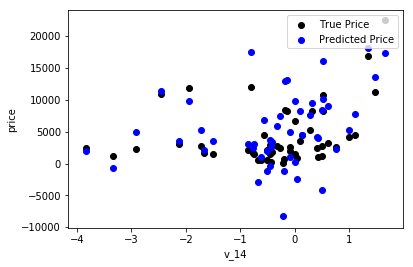

In [45]:
plt.scatter(train_X['v_14'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_14'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_14')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

看一下price几种处理方法的误差对比

In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

In [51]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

def normalize(data, columns_name):
    data_max = data[columns_name].max()
    data_min = data[columns_name].min()
    data[columns_name+'_max'] = data_max
    data[columns_name+'_min'] = data_min
    data[columns_name] = (data[columns_name] - data[columns_name+'_min'])/(data[columns_name+'_max']-data[columns_name+'_min'])
    return data

In [48]:
#不处理
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))
print('AVG:', np.mean(scores))

AVG: 1.4664435161411298


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


In [50]:
#对数处理
train_y_ln = np.log(train_y + 1)
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))
print('AVG:', math.exp(np.mean(scores))

AVG: 0.20451595954564877


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


In [104]:
#creatDate分组price归一化
f = [ 'creatDate_201604',
 'creatDate_201603',
 'creatDate_201602',
 'creatDate_201601',
 'creatDate_201511',
 'creatDate_201508',
 'creatDate_201509',
 'creatDate_201506',
 'creatDate_201512']
zero_array = np.array([0]*data.shape[0])
zero_array.reshape(-1,1)
my_one_hot_columns = f
data = train
train['price_1'] = train['price']
price_list = []
for i in range(len(my_one_hot_columns)):
    price_max = 0
    price_min = 0
    price_max = data[data[my_one_hot_columns[i]] == 1]['price_1'].max()
    price_min = data[data[my_one_hot_columns[i]] == 1]['price_1'].min()
    price_list.append([price_max,price_min])
data['month_price_min'] = zero_array
data['month_price_max'] = zero_array
for i in range(len(my_one_hot_columns)):
    data.loc[data[my_one_hot_columns[i]] == 1,'month_price_max'] = price_list[i][0]
    data.loc[data[my_one_hot_columns[i]] == 1,'month_price_min'] = price_list[i][1]
data['price_1'] = (data['price_1'] - data['month_price_min']) / (data['month_price_max'] - data['month_price_min'])
data_1 = data.dropna()
data_1.reset_index(drop=True)
train_X_1 = data_1[continuous_feature_names]
train_y_group = data_1['price_1']
train_y_group = 
scores = cross_val_score(model, X=train_X_1, y=train_y_group, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))
print('AVG:', train['price'].mean()*np.mean(scores))

AVG: 8.303736592804706


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


In [105]:
#creatDate分组price归一化+log
f = [ 'creatDate_201604',
 'creatDate_201603',
 'creatDate_201602',
 'creatDate_201601',
 'creatDate_201511',
 'creatDate_201508',
 'creatDate_201509',
 'creatDate_201506',
 'creatDate_201512']
zero_array = np.array([0]*data.shape[0])
zero_array.reshape(-1,1)
my_one_hot_columns = f
data = train
train['price_1'] = train['price']
price_list = []
for i in range(len(my_one_hot_columns)):
    price_max = 0
    price_min = 0
    price_max = data[data[my_one_hot_columns[i]] == 1]['price_1'].max()
    price_min = data[data[my_one_hot_columns[i]] == 1]['price_1'].min()
    price_list.append([price_max,price_min])
data['month_price_min'] = zero_array
data['month_price_max'] = zero_array
for i in range(len(my_one_hot_columns)):
    data.loc[data[my_one_hot_columns[i]] == 1,'month_price_max'] = price_list[i][0]
    data.loc[data[my_one_hot_columns[i]] == 1,'month_price_min'] = price_list[i][1]
data['price_1'] = (data['price_1'] - data['month_price_min']) / (data['month_price_max'] - data['month_price_min'])
data_1 = data.dropna()
data_1.reset_index(drop=True)
train_X_1 = data_1[continuous_feature_names]
train_y_group = data_1['price_1']
train_y_group = np.log(train_y_group + 1)
scores = cross_val_score(model, X=train_X_1, y=train_y_group, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))
print('AVG:', train['price'].mean()*np.mean(scores))

AVG: 15.494515045943217


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished


#### 3.1.1 误差分析
对price做对数变换得到的效果最好,对creatDate划分可能因为误差统计方法的原因，导致误差过大，该方法暂时搁置。

### 3.2 学习率曲线绘制

<module 'matplotlib.pyplot' from 'E:\\anaconda\\soft\\lib\\site-packages\\matplotlib\\pyplot.py'>

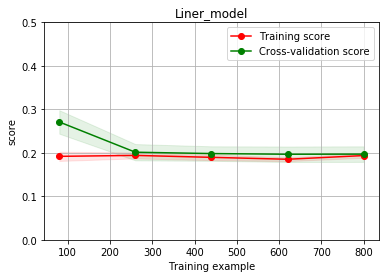

In [107]:
from sklearn.model_selection import learning_curve, validation_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt  
plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y_ln[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1) 

### 3.3 模型对比

In [111]:
train = train[continuous_feature_names].dropna()

train_X = train[continuous_feature_names].drop('price',axis=1)
train_y = train['price']
train_y_ln = np.log(train_y + 1)

In [112]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [113]:
models = [LinearRegression(),
          Ridge(),
          Lasso()]

In [114]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
Ridge is finished
Lasso is finished


In [118]:
train.head()

,name,kilometer,price,v_0,v_1,v_2,v_3,v_4,v_11,v_13,v_14,used_time,city,brand_amount,brand_price_average,brand_price_max,brand_price_median,brand_price_min,brand_price_std,brand_price_sum,power_bin,kilometer_max,kilometer_min,brand_amount_max,brand_amount_min,brand_price_average_max,brand_price_average_min,brand_price_max_max,brand_price_max_min,brand_price_median_max,brand_price_median_min,brand_price_min_max,brand_price_min_min,brand_price_std_max,brand_price_std_min,brand_price_std_min,brand_price_std_min,brand_price_std_min,brand_price_sum_max,brand_price_sum_min
0,736,0.827637,1850.0,43.34375,3.966797,0.050262,2.160156,1.143555,2.804688,0.795410,0.914551,4384.0,1.0,0.324463,0.073853,0.586914,0.029266,0.002064,0.186890,0.211548,5.0,15.0,0.5,31488.0,9.0,36160.0,1016.5,99999.0,2900.0,29984.0,950.0,980.0,11.0,22624.0,554.0,554.0,554.0,554.0,174253296.0,39488.0
1,2262,1.000000,3600.0,45.31250,5.234375,0.137939,1.380859,-1.421875,2.095703,-1.722656,0.245483,4756.0,4.0,0.437988,0.234985,0.999023,0.191040,0.004128,0.399414,0.733887,0.0,15.0,0.5,31488.0,9.0,36160.0,1016.5,99999.0,2900.0,29984.0,950.0,980.0,11.0,22624.0,554.0,554.0,554.0,554.0,174253296.0,39488.0
2,14874,0.827637,6222.0,45.96875,4.824219,1.319336,-0.998535,-0.997070,1.803711,-0.832520,-0.229980,4384.0,2.0,0.046051,0.251465,0.433594,0.260010,0.091858,0.220581,0.082275,16.0,15.0,0.5,31488.0,9.0,36160.0,1016.5,99999.0,2900.0,29984.0,950.0,980.0,11.0,22624.0,554.0,554.0,554.0,554.0,174253296.0,39488.0
3,71865,1.000000,2400.0,45.68750,4.492188,-0.050629,0.883789,-2.228516,1.286133,-2.437500,-0.478760,7124.0,0.0,0.452393,0.212158,0.979492,0.153198,0.004128,0.382080,0.692383,19.0,15.0,0.5,31488.0,9.0,36160.0,1016.5,99999.0,2900.0,29984.0,950.0,980.0,11.0,22624.0,554.0,554.0,554.0,554.0,174253296.0,39488.0
4,111080,0.310303,5200.0,44.37500,2.031250,0.572266,-1.571289,2.246094,0.910645,2.833984,1.923828,1531.0,6.0,0.147949,0.065125,0.294434,0.046478,0.009285,0.126343,0.088318,6.0,15.0,0.5,31488.0,9.0,36160.0,1016.5,99999.0,2900.0,29984.0,950.0,980.0,11.0,22624.0,554.0,554.0,554.0,554.0,174253296.0,39488.0


In [119]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,Ridge,Lasso
cv1,0.204168,0.204162,0.516419
cv2,0.204525,0.204514,0.515218
cv3,0.205581,0.205565,0.520136
cv4,0.202176,0.202170,0.506424
cv5,0.206130,0.206134,0.511673


intercept:2.98726949215677


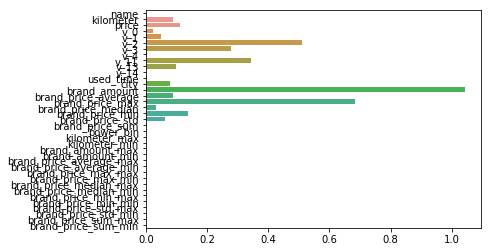

In [133]:
model = LinearRegression().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_[:-5]), continuous_feature_names)

intercept:4.06205251017977


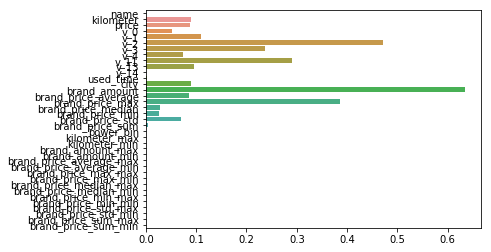

In [134]:
model = Ridge().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_[:-5]), continuous_feature_names)

intercept:4.712465377554216


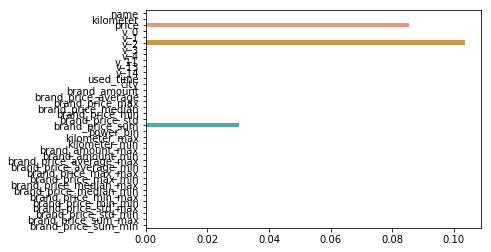

In [135]:
model = Lasso().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_[:-5]), continuous_feature_names)

* 对比发现，L2正则化对应的线性回归拟合过程中通常都倾向于让权值尽可能小，最后构造一个所有参数都比较小的模型，除非有确定性的证据使模型的参数变大。因为其认为参数值小的模型比较简单，能适应不同的数据集

* L1正则化有助于生成一个稀疏权值矩阵，进而可以用于特征选择。

* 决策树通过信息熵或GINI指数选择分裂节点时，优先选择的分裂特征也更加重要，这同样是一种特征选择的方法。

### 3.4 其他模型

In [136]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

E:\anaconda\soft\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [140]:
models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100), ]

In [141]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
DecisionTreeRegressor is finished
RandomForestRegressor is finished
GradientBoostingRegressor is finished
MLPRegressor is finished


In [142]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor
cv1,0.204168,0.210124,0.156028,0.187838,169.145183
cv2,0.204525,0.209684,0.156425,0.187203,259.110279
cv3,0.205581,0.211038,0.158829,0.188372,1.189862
cv4,0.202176,0.208940,0.155616,0.184363,0.849598
cv5,0.206130,0.208036,0.157123,0.189183,575.869959


从中我们看出随机森林在这个数据集上效果较好

### 3.5 模型调参

#### 3.5.1 调参方法简介
* 贪心算法--与正常贪心算法的思路相同，找到目前超参数使模型精度上升的方向前进，类似于优化方法中的梯度下降法，速度较快但是容易陷入局部极值，需要分析问题是否使用贪心算法，只有在凸优化问题中能确定找到最优解。

* 网格调参--通过建立超参数网格，即超参数的各种组合训练模型，从中返回最优的超参数，不易陷入局部极值，但速度较慢，难以找到最优解。

* 贝叶斯调参--类似于网格调参，贝叶斯优化通过基于目标函数的过去评估结果建立替代函数（概率模型），来找到最小化目标函数的值。贝叶斯方法与随机或网格搜索的不同之处在于，它在尝试下一组超参数时，会参考之前的评估结果，因此可以省去很多无用功。是对网格调参的一种优化。

由于该部分训练较慢，未运行完所有代码

In [143]:
objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']

num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,20,40, 55]
bagging_fraction = []
feature_fraction = []
drop_rate = []

In [144]:
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score
    
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score
    
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score

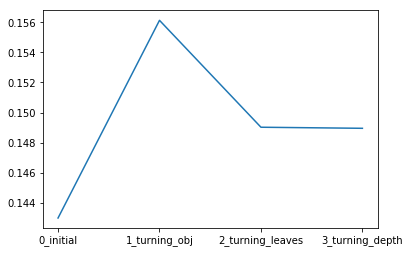

In [145]:
sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'], y=[0.143 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])

In [146]:
from sklearn.model_selection import GridSearchCV

In [147]:
parameters = {'objective': objective , 'num_leaves': num_leaves, 'max_depth': max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_X, train_y)

In [148]:
clf.best_params_

{'max_depth': 15, 'num_leaves': 55, 'objective': 'regression'}

In [149]:
model = LGBMRegressor(objective='regression',
                          num_leaves=55,
                          max_depth=15)

In [150]:
np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))

0.15123977815044354

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    val = cross_val_score(
        LGBMRegressor(objective = 'regression_l1',
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            subsample = subsample,
            min_child_samples = int(min_child_samples)
        ),
        X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)
    ).mean()
    return 1 - val

In [ ]:
rf_bo = BayesianOptimization(
    rf_cv,
    {
    'num_leaves': (2, 100),
    'max_depth': (2, 100),
    'subsample': (0.1, 1),
    'min_child_samples' : (2, 100)
    }
)

In [ ]:
rf_bo.maximize()

In [ ]:
1 - rf_bo.max['target']

# 4.总结

1.模型与调参是在特征工程之后，将特征以一定的学习思路，构建特征到标签的映射的部分。

2.模型的选择需要深入理解具体问题，并选择适用的模型，适用的模型能让预测得到更高的精度或更快的训练速度。

3.在了解了各种模型算法之后应对应具体问题选择不同的模型，同时，在模型训练过程中也可以通过学习率与最后学习到的参数指导进一步特征工程的实现。

4.超参数是现有模型训练中难以找到最优值的应填参数，在大多数情况下，超参数选取的影响小于模型选择，是作为确定模型针对特定问题与数据集提高精度与速度的一个参数。

5.超参数的调整方法目前了解到三种，贪心算法，网格搜索，贝叶斯优化，在确定贪心算法有效或可用情况下，贪心算法的超参数寻找速度与精度高于其他，贝叶斯优化考虑了原本训练数据的影响，将网格搜索简化，速度较快，网格搜索不易陷入局部极值，相较于其他两种算法拥有更高的确定最优解大致位置的可能性，但速度最慢